In [86]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS
pd.set_option('display.max_columns', None)

In [87]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, 0.8523)
test

'9.16'

In [88]:
def bonferroni(n_tests, coef, pvalue):
    coef = round(coef, 2)
    if pvalue >(.05/n_tests):
        coef = str(coef)
    if pvalue <= (.05/n_tests):
        coef = str(coef) + '*'
    if pvalue <= (.01/n_tests):
        coef = coef + '*'
    if pvalue <= (.001/n_tests):
        coef = coef + '*'
    return(coef)
test = bonferroni(4, .1, .005)
test

'0.1*'

In [89]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [90]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data.sample(5)

794


,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,distischarter,rating_academic,rating_financial,rating_academic_c,type,type_description,cntyname,students_amind_num,students_asian_num,students_black_num,students_cte_num,students_ell_num,students_frpl_num,students_hisp_num,students_num,students_num_d,students_paci_num,students_sped_num,students_tworaces_num,students_white_num,teachers_badegree_num,teachers_exp_ave,teachers_msdegree_num,teachers_new_num,teachers_nodegree_num,teachers_num,teachers_phddegree_num,teachers_tenure_ave,teachers_turnover_ratio_d,alg_avescore,bio_avescore,eng1_avescore,eng2_avescore,m_3rd_avescore,m_4th_avescore,m_5th_avescore,m_6th_avescore,m_7th_avescore,m_8th_avescore,r_3rd_avescore,r_4th_avescore,r_5th_avescore,r_6th_avescore,r_7th_avescore,r_8th_avescore,s_8th_avescore,us_avescore,alg_numtakers,bio_numtakers,eng1_numtakers,eng2_numtakers,m_3rd_numtakers,m_4th_numtakers,m_5th_numtakers,m_6th_numtakers,m_7th_numtakers,m_8th_numtakers,r_3rd_numtakers,r_4th_numtakers,r_5th_numtakers,r_6th_numtakers,r_7th_numtakers,r_8th_numtakers,s_8th_numtakers,us_numtakers,days_max,days_mean,days_min,class_size_1,class_size_2,class_size_3,class_size_4,class_size_5,class_size_6,class_size_k,class_size_sec_lang,class_size_sec_math,class_size_sec_r,class_size_sec_sci,class_size_sec_ss,stu_teach_ratio,Unnamed: 0_x,link,p_doi,doi_date,total,doi_year,_merge_x,doi,Unnamed: 0_y,_merge_y,cert_area_elem,cert_area_voc,cert_secondary_ela,cert_secondary_math,cert_secondary_sci,certification,certification_report,vocational,county,cnty_pop,students_frpl,students_black,students_hisp,students_white,students_ell,students_sped,students_cte,students_teacher_ratio,geography,charter,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree,r_3rd_std,m_3rd_std,r_4th_std,m_4th_std,r_5th_std,m_5th_std,r_6th_std,m_6th_std,r_7th_std,m_7th_std,r_8th_std,m_8th_std,s_8th_std,alg_std,bio_std,eng1_std,eng2_std,us_std,elem_math,elem_reading,elem,middle_math,middle_reading,middle_science,algebra,biology,eng1,avescores,treatpost,yearpost,yearpre,pre5,pre4,pre3,pre2,pre1,post1,post2,post3,test_by_year,math,reading
160459,186607,101920106,2015,m_4th_avescore,1495.0,-0.574940,HOUSMAN EL,N,101920,SPRING BRANCH ISD,N,M,Pass,M,B,MAJOR SUBURBAN,HARRIS,3,31,20,0,366,494,488,588,35041,0,44,6,40,31.8,16.600000,9.0,1,0.0,40.8000,0.0,12.900000,17.000000,NaN,NaN,NaN,NaN,1395.0,1495.0,1580.0,NaN,NaN,NaN,1399.0,1499.0,1516.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,72.0,77.0,NaN,NaN,NaN,67.0,42.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.8,16.8,17.7,19.5,22,.,20,.,.,.,.,.,14.400000,698.0,https://www.springbranchisd.com/about/board-of...,0.003759,2016-04-01,3.0,2017.0,both,True,4703.0,left_only,0.769231,NaN,NaN,NaN,NaN,1.0,1.0,NaN,HARRIS,4565.0,0.840136,0.034014,0.829932,0.068027,0.622449,0.074830,0.000000,14.411765,Suburban,False,doi,0,1,0,0,1,0.0,0.779412,0.220588,0.0,-0.497344,-0.776446,-0.126334,-0.528956,-0.626332,-0.206211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.503871,-0.416670,-0.460270,NaN,NaN,NaN,NaN,NaN,NaN,-0.460270,False,0.0,-2.0,0,0,0,1,0,0,0,0,m_4th_avescore2015,1,0
50736,62867,57914042,2016,m_7th_avescore,1615.0,-0.338821,VANSTON MIDDLE,N,57914,MESQUITE ISD,N,M,Pass,M,B,MAJOR SUBURBAN,DALLAS,5,7,180,170,121,646,520,798,40718,0,104,5,81,30.0,10.600000,23.1,2.8,0.0,53.1000,0.0,8.000000,15.900000,4442.0,NaN,4488.0,NaN,NaN,NaN,NaN,NaN,1615.0,1700.0,NaN,NaN,NaN,NaN,1607.0,1658.0,4047.0,NaN,71.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,283.0,345.0,NaN,NaN,NaN,NaN,358.0,338.0,365.0,NaN,NaN,NaN,NaN,.,.,.,.,.,.,.,26,17.3,16.2,16,17.3,15.000000,494.0,https://resources.finalsite.net/images/v154220...,0.000045,2017-08-01,7.0,2018.0,both,True,2373.0,left_only,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,DALLAS,2591.0,0.809524,0.225564,0.651629,0.101504,0.151629,0.130326,0.213033,15.028249,Suburban,False,doi,0,1,0,0,1,0.0,0.564972,0.435028,0.0,NaN,NaN,NaN,NaN,

# Create HTE Variables

In [91]:
data_pre = data.loc[data.pre1 == 1]
data_pre['pre_score'] = data_pre.groupby('campus')['score_std'].transform('mean')
data_pre = data_pre.drop_duplicates(subset = 'campus')
data_pre = data_pre.rename(columns = {'students_hisp': 'pre_hisp',
                                     'teachers_turnover_ratio_d': 'pre_turnover',
                                     'students_ell': 'pre_ell',
                                      'students_white': 'pre_white',
                                      'students_black': 'pre_black',
                                     'students_sped': 'pre_sped',
                                     'score_std': 'pre_avescore',
                                    'students_num': 'pre_num'})
data_pre_vars = ['campus', 'pre_hisp', 'pre_turnover', 'pre_ell', 'pre_white', 'pre_black', 'pre_sped', 'pre_avescore', 'pre_num']
data_pre = data_pre[data_pre_vars]
for var in ['pre_hisp', 'pre_ell', 'pre_white', 'pre_black', 
            'pre_sped', 'pre_num', 'pre_turnover', 'pre_avescore']:
    for p in [.25, .5, .75, 1]:
        num = str(int(p * 100))
        newvar = var + num
        if p == .25:
            data_pre[newvar] = np.where(data_pre[var] <= data_pre[var].quantile(p), 1, 0)
        if p > .25:
            lp = p - .25
            data_pre[newvar] = np.where(((data_pre[var] > data_pre[var].quantile(lp)) &
                                         (data_pre[var] <= data_pre[var].quantile(p))), 1, 0)
variables = ['campus']
variables = variables + (list(data_pre.filter(regex = ("pre_"))))
data_pre = data_pre[variables]
data_pre = data_pre.merge(data[data.year == 2016][['campus', 'type_urban', 'type_suburban', 'type_town', 'type_rural']], 
                          how = 'left', left_on = ['campus'], right_on = ['campus'])
data_pre = data_pre.rename(columns = {'type_urban': 'pre_urban',
                                      'type_suburban': 'pre_suburban',
                                      'type_town': 'pre_town',
                                      'type_rural': 'pre_rural'})
data_pre['pre_turnover'] = data_pre.pre_turnover / 100
data_pre.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,campus,pre_hisp,pre_turnover,pre_ell,pre_white,pre_black,pre_sped,pre_avescore,pre_num,pre_hisp25,pre_hisp50,pre_hisp75,pre_hisp100,pre_ell25,pre_ell50,pre_ell75,pre_ell100,pre_white25,pre_white50,pre_white75,pre_white100,pre_black25,pre_black50,pre_black75,pre_black100,pre_sped25,pre_sped50,pre_sped75,pre_sped100,pre_num25,pre_num50,pre_num75,pre_num100,pre_turnover25,pre_turnover50,pre_turnover75,pre_turnover100,pre_avescore25,pre_avescore50,pre_avescore75,pre_avescore100,pre_urban,pre_suburban,pre_town,pre_rural
26011,181906102,0.164498,0.249,0.092007,0.191450,0.549257,0.089219,-1.366783,1076,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0.0,0.0,1.0,0.0
31372,134901041,0.377778,0.256,0.029630,0.592593,0.000000,0.170370,-0.637159,135,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0.0,0.0,0.0,1.0
28084,15910130,0.575758,0.132,0.043290,0.278499,0.066378,0.112554,0.760816,693,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1.0,0.0,0.0,0.0
3492,235902044,0.513308,0.233,0.024081,0.400507,0.054499,0.103929,1.893064,789,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0.0,0.0,1.0,0.0
2052,107907001,0.128655,0.370,0.023392,0.666667,0.134503,0.146199,0.175756,171,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0.0,0.0,0.0,1.0


Text(0.04,0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

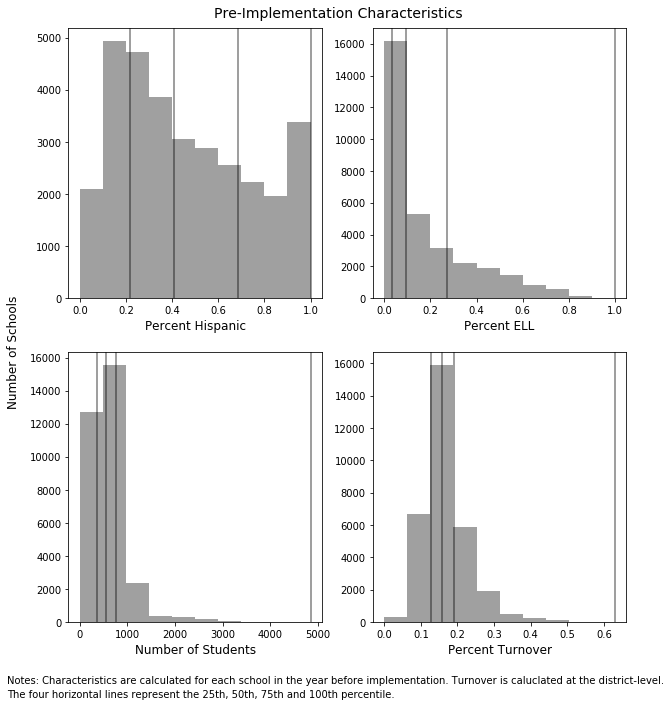

In [92]:
fig, ax = plt.subplots(2,2, sharey=False, sharex = False, figsize=(10, 10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]


bins = 10

ax1.hist(data_pre.pre_hisp, bins, facecolor='gray', alpha=0.75)
ax1.set_xlabel('Percent Hispanic', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax1.axvline(data_pre.pre_hisp.quantile(p), color = 'black', alpha = 0.5 )


ax2.hist(data_pre.pre_ell, bins, facecolor='gray', alpha=0.75)
ax2.set_xlabel('Percent ELL', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax2.axvline(data_pre.pre_ell.quantile(p), color = 'black', alpha = 0.5 )

ax3.hist(data_pre.pre_num,  bins, facecolor='gray', alpha=0.75)
ax3.set_xlabel('Number of Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax3.axvline(data_pre.pre_num.quantile(p), color = 'black', alpha = 0.5 )


ax4.hist(data_pre.pre_turnover.dropna(),  bins, facecolor='gray', alpha=0.75)
ax4.set_xlabel('Percent Turnover', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax4.axvline(data_pre.pre_turnover.quantile(p), color = 'black', alpha = 0.5 )


fig.text(0.04, 0.5, 'Number of Schools', va='center', rotation='vertical', fontsize = 12)
fig.suptitle('Pre-Implementation Characteristics', fontsize = 14)
fig.subplots_adjust(top=0.95)
fig.savefig(table_path + 'Pre-Implementation Characteristics.png')

fig.text(0.04, 0.04, 'Notes: Characteristics are calculated for each school in the year before implementation.'
        ' Turnover is caluclated at the district-level.')
fig.text(0.04, 0.02,'The four horizontal lines represent the 25th, 50th, 75th and 100th percentile.')

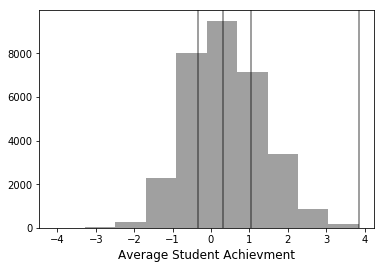

In [93]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.pre_avescore, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Average Student Achievment', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.pre_avescore.quantile(p), color = 'black', alpha = 0.5 )

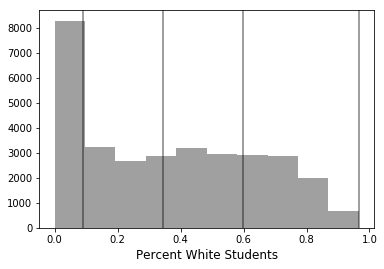

In [94]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.pre_white, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Percent White Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.pre_white.quantile(p), color = 'black', alpha = 0.5 )

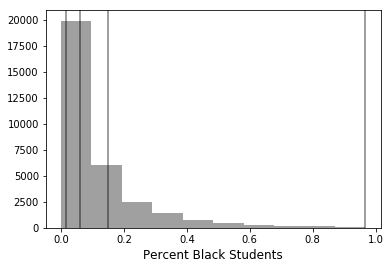

In [95]:
fig, ax = plt.subplots(1,1, sharey=True, sharex = False)


bins = 10

ax.hist(data_pre.pre_black, bins, facecolor='gray', alpha=0.75)
ax.set_xlabel('Percent Black Students', fontsize = 12)
for p in [.25, .5, .75, 1]:
    ax.axvline(data_pre.pre_black.quantile(p), color = 'black', alpha = 0.5 )

In [96]:
data = data.reset_index().set_index(['campus', 'test'])
data_pre = data_pre.reset_index().set_index(['campus'])
data.head()

index  Unnamed: 0  year   score  score_std  \
campus    test                                                         
109901001 alg_avescore        0           0  2012  4069.0  -0.002635   
          bio_avescore        1           1  2012  3852.0  -0.712471   
          eng1_avescore       2           2  2012  4076.0   0.501276   
          m_3rd_avescore      3           3  2012  1463.0   0.269832   
          m_4th_avescore      4           4  2012  1494.0  -0.590598   

                               campname campischarter  district    distname  \
campus    test                                                                
109901001 alg_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          bio_avescore    ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          eng1_avescore   ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_3rd_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   
          m_4th_avescore  ABBOTT SCHOOL             N    109901  ABBOTT ISD   

                         distischarter rating_academic rating_financial  \
campus    test                                                            
109901001 alg_avescore               N             NaN              NaN   
          bio_avescore               N             NaN              NaN   
          eng1_avescore              N             NaN              NaN   
          m_3rd_avescore             N             NaN              NaN   
          m_4th_avescore             N             NaN              NaN   

                         rating_academic_c type type_description cntyname  \
campus    test                                                              
109901001 alg_avescore                 NaN    H            RURAL     HILL   
          bio_avescore                 NaN    H            RURAL     HILL   
          eng1_avescore                NaN    H            RURAL     HILL   
          m_3rd_avescore               NaN    H            RURAL     HILL   
          m_4th_avescore               NaN    H            RURAL     HILL   

                          students_amind_num  students_asian_num  \
campus    test                                                     
109901001 alg_avescore                     0                   0   
          bio_avescore                     0                   0   
          eng1_avescore                    0                   0   
          m_3rd_avescore                   0                   0   
          m_4th_avescore                   0                   0   

                          students_black_num  students_cte_num  \
campus    test                                                   
109901001 alg_avescore                     1               115   
          bio_avescore                     1               115   
          eng1_avescore                    1               115   
          m_3rd_avescore                   1               115   
          m_4th_avescore                   1               115   

                          students_ell_num  students_frpl_num  \
campus    test                                                  
109901001 alg_avescore                   1                101   
          bio_avescore                   1                101   
          eng1_avescore                  1                101   
          m_3rd_avescore                 1                101   
          m_4th_avescore                 1                101   

                          students_hisp_num  students_num  students_num_d  \
campus    test                                                              
109901001 alg_avescore                   30           296             296   
          bio_avescore                   30           296             296   
          eng1_avescore                  30           296             296   
          m_3rd_avescore                 30           296             296   
          m_4th_avescore                 30

In [97]:
data_hte = data.reset_index().merge(data_pre, left_on = 'campus', right_on = 'campus', how = 'left')
data_hte.head(5)

,campus,test,index_x,Unnamed: 0,year,score,score_std,campname,campischarter,district,distname,distischarter,rating_academic,rating_financial,rating_academic_c,type,type_description,cntyname,students_amind_num,students_asian_num,students_black_num,students_cte_num,students_ell_num,students_frpl_num,students_hisp_num,students_num,students_num_d,students_paci_num,students_sped_num,students_tworaces_num,students_white_num,teachers_badegree_num,teachers_exp_ave,teachers_msdegree_num,teachers_new_num,teachers_nodegree_num,teachers_num,teachers_phddegree_num,teachers_tenure_ave,teachers_turnover_ratio_d,alg_avescore,bio_avescore,eng1_avescore,eng2_avescore,m_3rd_avescore,m_4th_avescore,m_5th_avescore,m_6th_avescore,m_7th_avescore,m_8th_avescore,r_3rd_avescore,r_4th_avescore,r_5th_avescore,r_6th_avescore,r_7th_avescore,r_8th_avescore,s_8th_avescore,us_avescore,alg_numtakers,bio_numtakers,eng1_numtakers,eng2_numtakers,m_3rd_numtakers,m_4th_numtakers,m_5th_numtakers,m_6th_numtakers,m_7th_numtakers,m_8th_numtakers,r_3rd_numtakers,r_4th_numtakers,r_5th_numtakers,r_6th_numtakers,r_7th_numtakers,r_8th_numtakers,s_8th_numtakers,us_numtakers,days_max,days_mean,days_min,class_size_1,class_size_2,class_size_3,class_size_4,class_size_5,class_size_6,class_size_k,class_size_sec_lang,class_size_sec_math,class_size_sec_r,class_size_sec_sci,class_size_sec_ss,stu_teach_ratio,Unnamed: 0_x,link,p_doi,doi_date,total,doi_year,_merge_x,doi,Unnamed: 0_y,_merge_y,cert_area_elem,cert_area_voc,cert_secondary_ela,cert_secondary_math,cert_secondary_sci,certification,certification_report,vocational,county,cnty_pop,students_frpl,students_black,students_hisp,students_white,students_ell,students_sped,students_cte,students_teacher_ratio,geography,charter,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree,r_3rd_std,m_3rd_std,r_4th_std,m_4th_std,r_5th_std,m_5th_std,r_6th_std,m_6th_std,r_7th_std,m_7th_std,r_8th_std,m_8th_std,s_8th_std,alg_std,bio_std,eng1_std,eng2_std,us_std,elem_math,elem_reading,elem,middle_math,middle_reading,middle_science,algebra,biology,eng1,avescores,treatpost,yearpost,yearpre,pre5,pre4,pre3,pre2,pre1,post1,post2,post3,test_by_year,math,reading,index_y,pre_hisp,pre_turnover,pre_ell,pre_white,pre_black,pre_sped,pre_avescore,pre_num,pre_hisp25,pre_hisp50,pre_hisp75,pre_hisp100,pre_ell25,pre_ell50,pre_ell75,pre_ell100,pre_white25,pre_white50,pre_white75,pre_white100,pre_black25,pre_black50,pre_black75,pre_black100,pre_sped25,pre_sped50,pre_sped75,pre_sped100,pre_num25,pre_num50,pre_num75,pre_num100,pre_turnover25,pre_turnover50,pre_turnover75,pre_turnover100,pre_avescore25,pre_avescore50,pre_avescore75,pre_avescore100,pre_urban,pre_suburban,pre_town,pre_rural
0,109901001,alg_avescore,0,0,2012,4069.0,-0.002635,ABBOTT SCHOOL,N,109901,ABBOTT ISD,N,NaN,NaN,NaN,H,RURAL,HILL,0,0,1,115,1,101,30,296,296,0,37,9,256,NaN,17.541667,NaN,0,NaN,22.9742,NaN,13.75,8.174,4069.0,3852.0,4076.0,NaN,1463.0,1494.0,1545.0,1700.0,1688.0,1693.0,1466.0,1512.0,1539.0,1647.0,1690.0,1699.0,3808.0,NaN,26.0,26.0,26.0,NaN,16.0,22.0,20.0,17.0,15.0,26.0,16.0,22.0,21.0,19.0,16.0,26.0,26.0,NaN,NaN,NaN,NaN,21,21,17,22,20.6,11.6,20,9.3,11.7,8.5,12.7,16.2,12.884018,0.0,https://www.abbottisd.org/ourpages/auto/2018/3...,0.999955,2018-03-01,11.0,2018.0,both,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HILL,36.0,0.341216,0.003378,0.101351,0.864865,0.003378,0.125,0.388514,12.884018,Rural,False,doi,0,0,0,1,1,NaN,NaN,NaN,NaN,0.712273,0.333386,0.093541,-0.545061,-0.232009,-0.767251,1.064115,1.31147,0.993662,0.843115,0.51854,0.774769,0.159776,0.088879,-0.592073,0.577864,NaN,NaN,-0.326309,0.191269,-0.06752,0.976451,0.858772,0.159776,0.088879,-0.592073,0.577864,0.317142,False,0.0,-5.0,1,0,0,0,0,0,0,0,alg_avescore2012,1,0,7564.0,0.127208,0.165,0.003534,0.840989,0.007067,0.109541,-0.145347,283.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [98]:
#convert year to datetime
df = data_hte.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = df.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5, random_state = 8)

,,district,doi_year,treatpost
campus,year,,,
15910127,2017-01-01,15910,2019.0,False
57905268,2014-01-01,57905,2018.0,False
146905101,2019-01-01,146905,2018.0,True
101919043,2013-01-01,101919,2018.0,False
101920114,2014-01-01,101920,2017.0,False


In [99]:
gdid_model = 'score_std ~ + 1 + treatpost + C(test_by_year) + EntityEffects'
linear_gdid_model = 'score_std ~ + 1 + treatpost + yearpost + yearpre  + C(test_by_year) + EntityEffects'
event_study_model = 'score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3  + C(test_by_year) + EntityEffects'

# Event-study HTE Model

### Set up table

In [ ]:
file = table_path + 'table5_hte_math.xlsx'
wb = load_workbook(file)
ws = wb.active

In [100]:
event_study_model = 'score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3  + C(test_by_year) + EntityEffects'

In [101]:
def results_table(data, col, var, q_vars):
    event_study_model = 'score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + '
    for preyr in [5, 4, 3, 2]:
        for p in q_vars:
            prevar = 'pre' + str(preyr) + var + str(p)
            oldprevar = 'pre' + str(preyr)
            oldcovar = var + str(p)
            data[prevar] = data[oldprevar] * data[oldcovar]
            event_study_model = event_study_model + prevar + ' + '
    postvars = []
    for postyr in [1, 2, 3]:
        postvars.append('post' + str(postyr))
        for p in q_vars:    
            postvar = 'post' + str(postyr) + var + str(p)
            postvars.append(postvar)
            oldpostvar = 'post' + str(postyr)
            oldcovar = var + str(p) 
            data[postvar] = data[oldpostvar] * data[oldcovar]
            event_study_model = event_study_model + postvar + ' + '    
    event_study_model = event_study_model + ' C(test_by_year) + EntityEffects'
    print(event_study_model)
    # Event Study
    mod = PanelOLS.from_formula(event_study_model, data)
    res = mod.fit(cov_type='clustered', clusters= data.district)
    print(postvars)
    print(res)
    row = 3
    for coef in postvars:
        ws.cell(row= row, column= col).value = coef_with_stars(res.params[coef], res.pvalues[coef])
        row = row + 1
        ws.cell(row= row, column= col).value = format_se(res.std_errors[coef])  
        row = row + 1    
    
    wb.save(file)


/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_suburban + pre5pre_town + pre5pre_rural + pre4pre_suburban + pre4pre_town + pre4pre_rural + pre3pre_suburban + pre3pre_town + pre3pre_rural + pre2pre_suburban + pre2pre_town + pre2pre_rural + post1pre_suburban + post1pre_town + post1pre_rural + post2pre_suburban + post2pre_town + post2pre_rural + post3pre_suburban + post3pre_town + post3pre_rural +  C(test_by_year) + EntityEffects


/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


['post1', 'post1pre_suburban', 'post1pre_town', 'post1pre_rural', 'post2', 'post2pre_suburban', 'post2pre_town', 'post2pre_rural', 'post3', 'post3pre_suburban', 'post3pre_town', 'post3pre_rural']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2141
Estimator:                   PanelOLS   R-squared (Between):             -0.3762
No. Observations:              810995   R-squared (Within):               0.2141
Date:                Thu, Feb 06 2020   R-squared (Overall):              0.0163
Time:                        18:55:34   Log-likelihood                -6.731e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2642.8
Entities:                        5598   P-value                           0.0000
Avg Obs:                       144.87   Distribution:               F(83,80

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_turnover50 + pre5pre_turnover75 + pre5pre_turnover100 + pre4pre_turnover50 + pre4pre_turnover75 + pre4pre_turnover100 + pre3pre_turnover50 + pre3pre_turnover75 + pre3pre_turnover100 + pre2pre_turnover50 + pre2pre_turnover75 + pre2pre_turnover100 + post1pre_turnover50 + post1pre_turnover75 + post1pre_turnover100 + post2pre_turnover50 + post2pre_turnover75 + post2pre_turnover100 + post3pre_turnover50 + post3pre_turnover75 + post3pre_turnover100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_turnover50', 'post1pre_turnover75', 'post1pre_turnover100', 'post2', 'post2pre_turnover50', 'post2pre_turnover75', 'post2pre_turnover100', 'post3', 'post3pre_turnover50', 'post3pre_turnover75', 'post3pre_turnover100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2155
Estimator:                   PanelOLS   

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_avescore50 + pre5pre_avescore75 + pre5pre_avescore100 + pre4pre_avescore50 + pre4pre_avescore75 + pre4pre_avescore100 + pre3pre_avescore50 + pre3pre_avescore75 + pre3pre_avescore100 + pre2pre_avescore50 + pre2pre_avescore75 + pre2pre_avescore100 + post1pre_avescore50 + post1pre_avescore75 + post1pre_avescore100 + post2pre_avescore50 + post2pre_avescore75 + post2pre_avescore100 + post3pre_avescore50 + post3pre_avescore75 + post3pre_avescore100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_avescore50', 'post1pre_avescore75', 'post1pre_avescore100', 'post2', 'post2pre_avescore50', 'post2pre_avescore75', 'post2pre_avescore100', 'post3', 'post3pre_avescore50', 'post3pre_avescore75', 'post3pre_avescore100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2210
Estimator:                   PanelOLS   

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_hisp50 + pre5pre_hisp75 + pre5pre_hisp100 + pre4pre_hisp50 + pre4pre_hisp75 + pre4pre_hisp100 + pre3pre_hisp50 + pre3pre_hisp75 + pre3pre_hisp100 + pre2pre_hisp50 + pre2pre_hisp75 + pre2pre_hisp100 + post1pre_hisp50 + post1pre_hisp75 + post1pre_hisp100 + post2pre_hisp50 + post2pre_hisp75 + post2pre_hisp100 + post3pre_hisp50 + post3pre_hisp75 + post3pre_hisp100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_hisp50', 'post1pre_hisp75', 'post1pre_hisp100', 'post2', 'post2pre_hisp50', 'post2pre_hisp75', 'post2pre_hisp100', 'post3', 'post3pre_hisp50', 'post3pre_hisp75', 'post3pre_hisp100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2151
Estimator:                   PanelOLS   R-squared (Between):             -0.3766
No. Observations:              811261   R-squared (Within):               0.215

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_black50 + pre5pre_black75 + pre5pre_black100 + pre4pre_black50 + pre4pre_black75 + pre4pre_black100 + pre3pre_black50 + pre3pre_black75 + pre3pre_black100 + pre2pre_black50 + pre2pre_black75 + pre2pre_black100 + post1pre_black50 + post1pre_black75 + post1pre_black100 + post2pre_black50 + post2pre_black75 + post2pre_black100 + post3pre_black50 + post3pre_black75 + post3pre_black100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_black50', 'post1pre_black75', 'post1pre_black100', 'post2', 'post2pre_black50', 'post2pre_black75', 'post2pre_black100', 'post3', 'post3pre_black50', 'post3pre_black75', 'post3pre_black100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2160
Estimator:                   PanelOLS   R-squared (Between):             -0.3866
No. Observations:              811261   R-squared

In [ ]:
results_table(df[df.math == 1], 2,'pre_', ['suburban', 'town', 'rural'])
results_table(df[df.math == 1], 3,'pre_turnover', ['50', '75', '100'])
results_table(df[df.math == 1], 4,'pre_avescore', ['50', '75', '100'])
results_table(df[df.math == 1], 5,'pre_hisp',['50', '75', '100'])
results_table(df[df.math == 1], 6,'pre_black',['50', '75', '100'])

In [103]:
file = table_path + 'table6_hte_reading.xlsx'
wb = load_workbook(file)
ws = wb.active

In [104]:
results_table(df[df.reading == 1], 2,'pre_', ['suburban', 'town', 'rural'])
results_table(df[df.reading == 1], 3,'pre_turnover', ['50', '75', '100'])
results_table(df[df.reading == 1], 4,'pre_avescore', ['50', '75', '100'])
results_table(df[df.reading == 1], 5,'pre_hisp',['50', '75', '100'])
results_table(df[df.reading == 1], 6,'pre_black',['50', '75', '100'])

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_suburban + pre5pre_town + pre5pre_rural + pre4pre_suburban + pre4pre_town + pre4pre_rural + pre3pre_suburban + pre3pre_town + pre3pre_rural + pre2pre_suburban + pre2pre_town + pre2pre_rural + post1pre_suburban + post1pre_town + post1pre_rural + post2pre_suburban + post2pre_town + post2pre_rural + post3pre_suburban + post3pre_town + post3pre_rural +  C(test_by_year) + EntityEffects


/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


['post1', 'post1pre_suburban', 'post1pre_town', 'post1pre_rural', 'post2', 'post2pre_suburban', 'post2pre_town', 'post2pre_rural', 'post3', 'post3pre_suburban', 'post3pre_town', 'post3pre_rural']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1201
Estimator:                   PanelOLS   R-squared (Between):             -0.1106
No. Observations:              760500   R-squared (Within):               0.1201
Date:                Thu, Feb 06 2020   R-squared (Overall):             -0.0021
Time:                        21:02:42   Log-likelihood                -4.954e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1240.7
Entities:                        5597   P-value                           0.0000
Avg Obs:                       135.88   Distribution:               F(83,75

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_turnover50 + pre5pre_turnover75 + pre5pre_turnover100 + pre4pre_turnover50 + pre4pre_turnover75 + pre4pre_turnover100 + pre3pre_turnover50 + pre3pre_turnover75 + pre3pre_turnover100 + pre2pre_turnover50 + pre2pre_turnover75 + pre2pre_turnover100 + post1pre_turnover50 + post1pre_turnover75 + post1pre_turnover100 + post2pre_turnover50 + post2pre_turnover75 + post2pre_turnover100 + post3pre_turnover50 + post3pre_turnover75 + post3pre_turnover100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_turnover50', 'post1pre_turnover75', 'post1pre_turnover100', 'post2', 'post2pre_turnover50', 'post2pre_turnover75', 'post2pre_turnover100', 'post3', 'post3pre_turnover50', 'post3pre_turnover75', 'post3pre_turnover100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1233
Estimator:                   PanelOLS   

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_avescore50 + pre5pre_avescore75 + pre5pre_avescore100 + pre4pre_avescore50 + pre4pre_avescore75 + pre4pre_avescore100 + pre3pre_avescore50 + pre3pre_avescore75 + pre3pre_avescore100 + pre2pre_avescore50 + pre2pre_avescore75 + pre2pre_avescore100 + post1pre_avescore50 + post1pre_avescore75 + post1pre_avescore100 + post2pre_avescore50 + post2pre_avescore75 + post2pre_avescore100 + post3pre_avescore50 + post3pre_avescore75 + post3pre_avescore100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_avescore50', 'post1pre_avescore75', 'post1pre_avescore100', 'post2', 'post2pre_avescore50', 'post2pre_avescore75', 'post2pre_avescore100', 'post3', 'post3pre_avescore50', 'post3pre_avescore75', 'post3pre_avescore100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1295
Estimator:                   PanelOLS   

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_hisp50 + pre5pre_hisp75 + pre5pre_hisp100 + pre4pre_hisp50 + pre4pre_hisp75 + pre4pre_hisp100 + pre3pre_hisp50 + pre3pre_hisp75 + pre3pre_hisp100 + pre2pre_hisp50 + pre2pre_hisp75 + pre2pre_hisp100 + post1pre_hisp50 + post1pre_hisp75 + post1pre_hisp100 + post2pre_hisp50 + post2pre_hisp75 + post2pre_hisp100 + post3pre_hisp50 + post3pre_hisp75 + post3pre_hisp100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_hisp50', 'post1pre_hisp75', 'post1pre_hisp100', 'post2', 'post2pre_hisp50', 'post2pre_hisp75', 'post2pre_hisp100', 'post3', 'post3pre_hisp50', 'post3pre_hisp75', 'post3pre_hisp100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1239
Estimator:                   PanelOLS   R-squared (Between):             -0.1007
No. Observations:              760758   R-squared (Within):               0.123

score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + post1 + post2 + post3 + pre5pre_black50 + pre5pre_black75 + pre5pre_black100 + pre4pre_black50 + pre4pre_black75 + pre4pre_black100 + pre3pre_black50 + pre3pre_black75 + pre3pre_black100 + pre2pre_black50 + pre2pre_black75 + pre2pre_black100 + post1pre_black50 + post1pre_black75 + post1pre_black100 + post2pre_black50 + post2pre_black75 + post2pre_black100 + post3pre_black50 + post3pre_black75 + post3pre_black100 +  C(test_by_year) + EntityEffects
['post1', 'post1pre_black50', 'post1pre_black75', 'post1pre_black100', 'post2', 'post2pre_black50', 'post2pre_black75', 'post2pre_black100', 'post3', 'post3pre_black50', 'post3pre_black75', 'post3pre_black100']
                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.1241
Estimator:                   PanelOLS   R-squared (Between):             -0.1197
No. Observations:              760758   R-squared

# Graphs

In [124]:
def results_graph(data, var, q_vars, labels, title):
    event_study_model = 'score_std ~ + 1 + '
    for preyr in [5, 4, 3, 2]:
        for p in q_vars:
            prevar = 'pre' + str(preyr) + var + str(p)
            oldprevar = 'pre' + str(preyr)
            oldcovar = var + str(p)
            data[prevar] = data[oldprevar] * data[oldcovar]
            event_study_model = event_study_model + prevar + ' + '
    postvars = []
    for postyr in [1, 2, 3]:
        postvars.append('post' + str(postyr))
        for p in q_vars:    
            postvar = 'post' + str(postyr) + var + str(p)
            postvars.append(postvar)
            oldpostvar = 'post' + str(postyr)
            oldcovar = var + str(p) 
            data[postvar] = data[oldpostvar] * data[oldcovar]
            event_study_model = event_study_model + postvar + ' + '    
    event_study_model = event_study_model + ' C(test_by_year) + EntityEffects'
    # Event Study
    mod = PanelOLS.from_formula(event_study_model, data)
    res = mod.fit(cov_type='clustered', clusters= data.district)

    fig, ax = plt.subplots(2,2, sharey=False, sharex = False, figsize=(10, 10))

    ax1 = ax[0,0]
    ax2 = ax[0,1]
    ax3 = ax[1,0]
    ax4 = ax[1,1]

    for ax, p, q in zip ([ax1, ax2, ax3, ax4], q_vars, labels):
        nonparametric = []
        nonparametric_se = []
        for coef in ['pre5' + var +  p , 'pre4' + var + p, 'pre3' + var + p, 'pre2'  + var + p, 'pre1' + var + p, 'post1'  + var + p, 'post2'  + var + p, 'post3'  + var + p]:
            nonpar = 0
            nonpar_se = 0
            if coef != 'pre1'  + var + p:
                nonpar = res.params[coef]
                nonpar_se = res.std_errors[coef]
            nonparametric.append(nonpar)
            nonparametric_se.append(nonpar_se)
        coef_df = pd.DataFrame({'coef': nonparametric,
                                'err': nonparametric_se,
                                'year': [-5, -4, -3, -2, -1, 1, 2, 3]
                               })
        coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
        coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
        coef_df['errsig'] = coef_df.err *1.96

        #fig, ax = plt.subplots(figsize=(8, 5))

        coef_df.plot(x='year', y='coef', kind='bar', 
                     ax=ax, color='none', 
                     yerr='errsig', legend=False)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
                   marker='s', s=120, 
                   y=coef_df['coef'], color='black')
        ax.axhline(y=0, linestyle='--', color='black', linewidth=2)
        ax.xaxis.set_ticks_position('none')
        _ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Post1', 'Post2', 'Post3'], 
                               rotation=0)
        ax.set_title('District Type ' + q, fontsize = 16)
        fig.savefig(table_path + title)


## Urbanicity

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

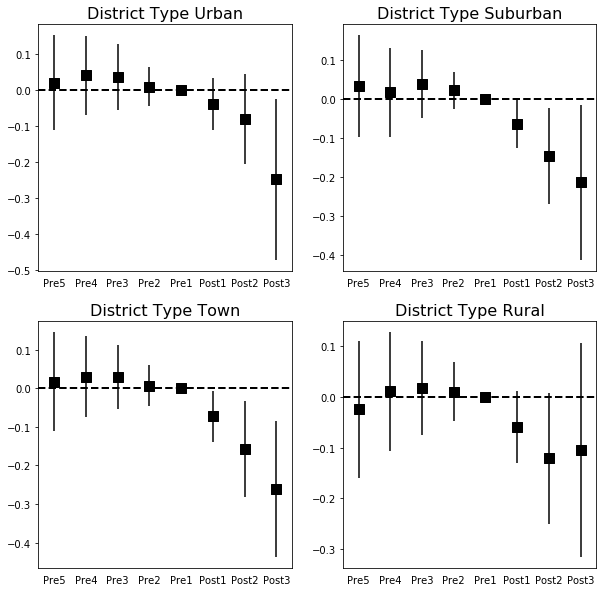

In [125]:
results_graph(df[df.math == 1], 'pre_', ['urban', 'suburban', 'town', 'rural'],
              ['Urban', 'Suburban', 'Town', 'Rural'],  'Event Study Math Urbanicity.png')

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

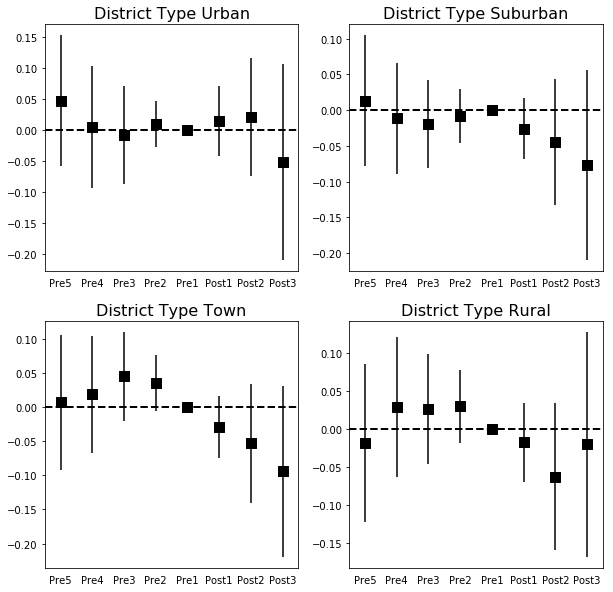

In [126]:
results_graph(df[df.reading == 1], 'pre_', ['urban', 'suburban', 'town', 'rural'],
              ['Urban', 'Suburban', 'Town', 'Rural'],  'Event Study Reading Urbanicity.png')

## Turnover

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

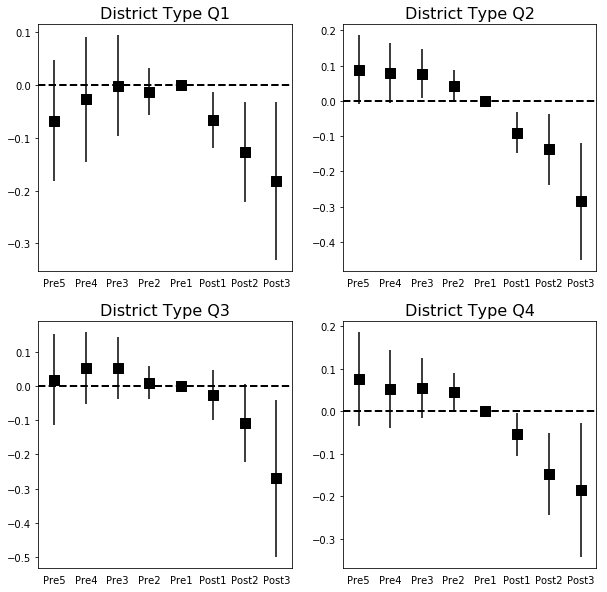

In [127]:
results_graph(df[df.math == 1], 'pre_turnover', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Math Teacher Turnover.png')

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

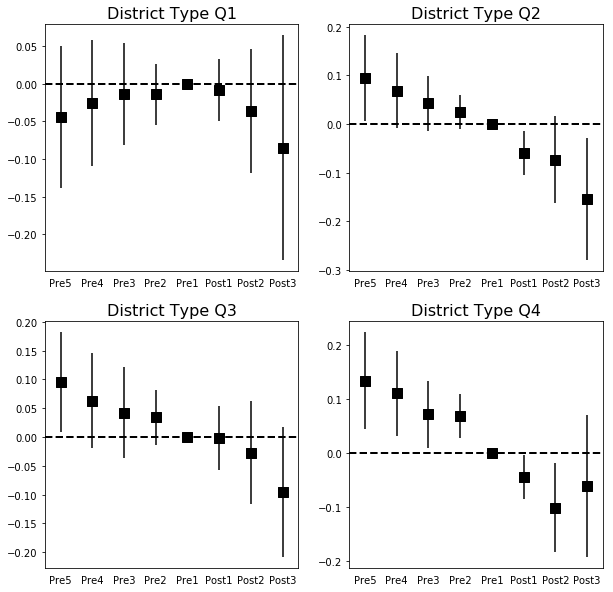

In [128]:
results_graph(df[df.reading == 1], 'pre_turnover', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Reading Teacher Turnover.png')

## Prior Achievement

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

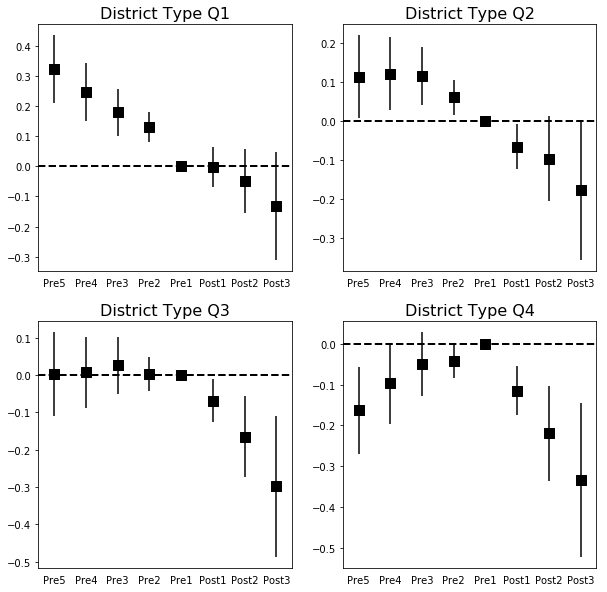

In [129]:
results_graph(df[df.math == 1], 'pre_avescore', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Math Prior Achievement.png')

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

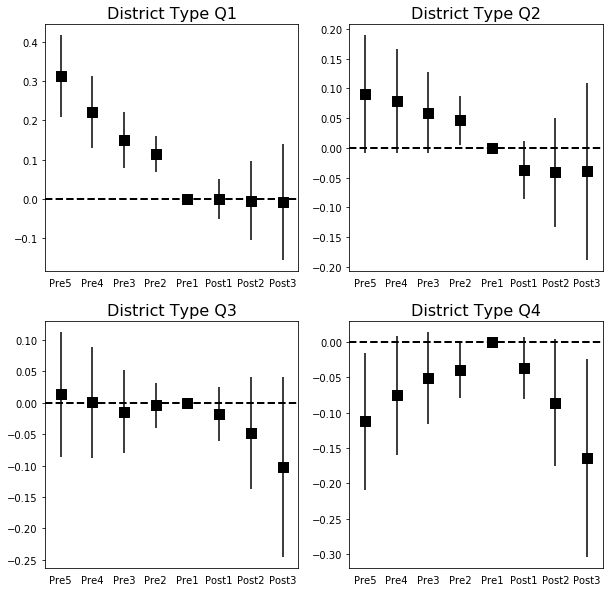

In [130]:
results_graph(df[df.reading == 1], 'pre_avescore', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Reading Prior Achievement.png')

## Percent Hispanic

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

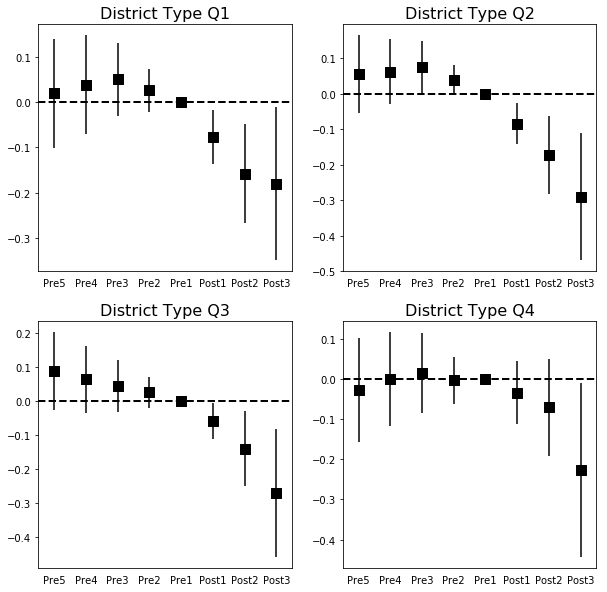

In [132]:
results_graph(df[df.math == 1], 'pre_hisp', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Math Percent Hispanic.png')

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

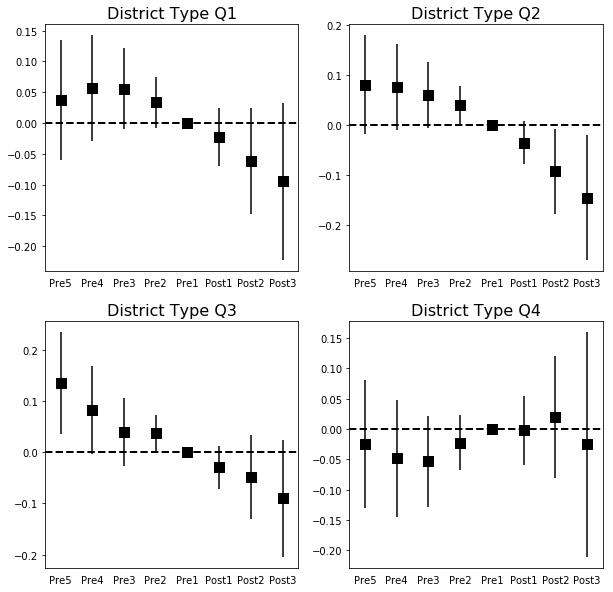

In [133]:
results_graph(df[df.reading == 1], 'pre_hisp', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Reading Percent Hispanic.png')

In [ ]:
## Percent Black

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

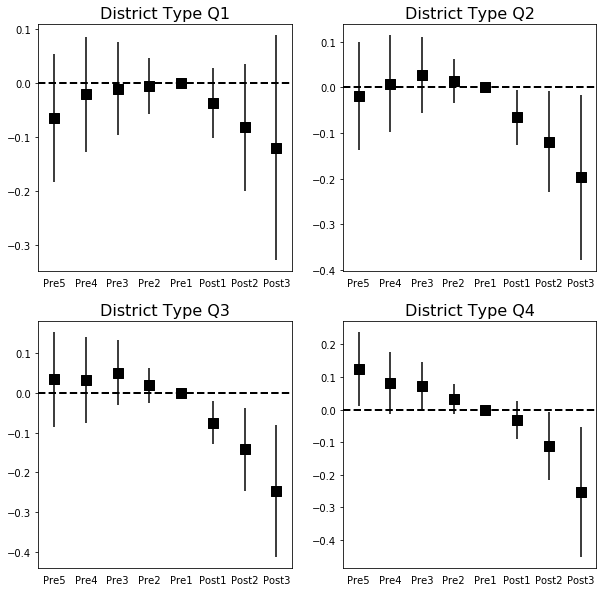

In [134]:
results_graph(df[df.math == 1], 'pre_black', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Math Percent Black.png')

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_war

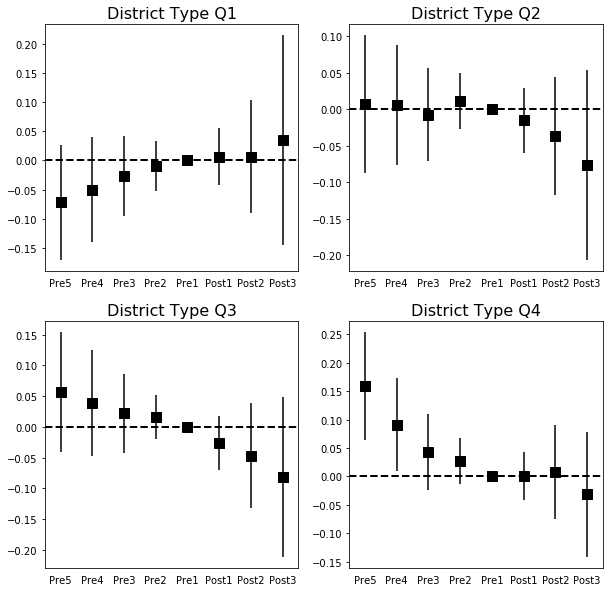

In [135]:
results_graph(df[df.reading == 1], 'pre_black', ['25', '50', '75', '100'],
              ['Q1', 'Q2', 'Q3', 'Q4'],  'Event Study Reading Percent Black.png')